In [ ]:
### author: Chen Zheng
### 10/01/2022

In [ ]:
# !pip install d2l
# !pip install matplotlib==3.0
# !pip install matplotlib_inline

In [ ]:
from d2l import torch as d2l
import os
import torch     
from torch import nn  
##########################################################################################################################
# In this task, we choose a famous dataset, Large Movie Review Dataset (IMDB), as the Sentiment Analysis benchmark.
# The data link is shown in here: https://ai.stanford.edu/~amaas/data/sentiment/ .
##########################################################################################################################  

In [ ]:
##########################################################################################################################
# Set up the hyper-parameters.
print('-----------------------------start set up heper-parameter-----------------------------')
##########################################################################################################################
batch_size = 64

embed_size = 100
kernel_sizes = [3]
num_channels = [100]
# kernel_sizes = [3, 4, 5]
# num_channels = [100, 100, 100]
devices = d2l.try_all_gpus()

learning_rate = 1e-3
train_epochs = 5

dropout_rate = 0.5 ## the range from 0 to 1

sentence = "a very well-made, funny and entertaining picture."

print('-----------------------------end set up heper-parameter----------------------------')

-----------------------------start set up heper-parameter-----------------------------
-----------------------------end set up heper-parameter----------------------------


In [ ]:
##########################################################################################################################
# data preprocessing
print('-----------------------------start loading data and data preprocessing-----------------------------')
##########################################################################################################################
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size) ### data preprocessing will spend more time.
print('-----------------------------end loading data and data preprocessing-----------------------------')

-----------------------------start loading data and data preprocessing-----------------------------
-----------------------------end loading data and data preprocessing-----------------------------


In [ ]:
##########################################################################################################################
# Create the Convolutional Neural Network on Sentiment Analysis Task.
##########################################################################################################################
class Sentiment_Analysis_CNN(nn.Module):                                                     
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):

        super(Sentiment_Analysis_CNN, self).__init__(**kwargs)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)

        self.dropout = nn.Dropout(dropout_rate)
        self.sentiment_analysis_classification = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()

        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))                     

    def forward(self, inputs):
    
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        embeddings = embeddings.permute(0, 2, 1)
        encoding = torch.cat(
            [torch.squeeze
                (self.relu(self.pool(conv(embeddings))), dim=-1) for conv in self.convs
            ], 
            dim=1)
        outputs = self.sentiment_analysis_classification(self.dropout(encoding))
        return outputs

In [ ]:
##########################################################################################################################
# Initialize the weights.
##########################################################################################################################
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

In [ ]:
##########################################################################################################################
# Instance the CNN and put the Glove embedding into the model
print('-----------------------------start Instance the CNN model-----------------------------')
##########################################################################################################################
glove_embedding = d2l.TokenEmbedding("glove.6b.100d") ### load embedding will spend more time.
embeds = glove_embedding[vocab.idx_to_token]
net = Sentiment_Analysis_CNN(len(vocab), embed_size, kernel_sizes, num_channels)
net.apply(init_weights)
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False
print('-----------------------------end Instance the CNN model-----------------------------')

-----------------------------start Instance the CNN model-----------------------------
-----------------------------end Instance the CNN model-----------------------------


loss 0.001, train acc 0.973, test acc 0.878
182.4 examples/sec on [device(type='cpu')]
-----------------------------end training process-----------------------------


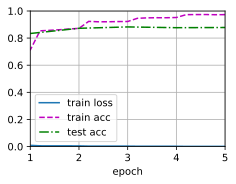

In [ ]:
##########################################################################################################################
# Train the model.
print('-----------------------------start training process-----------------------------')
##########################################################################################################################
trainer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, train_epochs, devices)
print('-----------------------------end training process-----------------------------')

In [ ]:
##########################################################################################################################
# Test the model.
print('-----------------------------start testing process-----------------------------')
##########################################################################################################################

sentence_tensor = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())

label = torch.argmax(
        net(sentence_tensor.reshape(1, -1)), 
        axis=1
    )
if label == 1:
    print('The result is positive!')
else:
    print('The result is negative!')

-----------------------------start testing process-----------------------------
The result is positive!
